# 2a. Supervised Modeling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import pickle

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score

pd.set_option('display.max_colwidth', -1)

C:\Users\templ\Anaconda3\envs\dsi\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Exploratory Data Analysis and Preproccessing

In [2]:
# import tweets
tweets = pd.read_csv('../data/Tweets_Historical/historic_tweets_official_07262019.csv')

In [3]:
tweets.head()

,date,geo,hashtags,id,text,type,username
0,2016-10-11 16:39:51+00:00,NaN,NaN,785882618852147201,The PIOH for the SR 138/I-20 is going on now until 8 p.m.pic.twitter.com/UVsI1GJOll – at American Legion Post 77,official,GDOTATL
1,2016-10-10 19:10:23+00:00,NaN,NaN,785558112682053632,We appreciate all the hard work our crews have done the last few days. They were incredibly dedicated to getting you home safe! PC: J.Coferpic.twitter.com/YunOqjiyNO,official,GDOTATL
2,2016-10-09 17:30:22+00:00,NaN,NaN,785170555456647168,Need info on re-entry? Check here! Also follow our partners. @511Georgia @GeorgiaEMApic.twitter.com/ycEJuAsgOd,official,GDOTATL
3,2016-10-09 15:45:11+00:00,NaN,NaN,785144083685793792,Do you need some updates? You can find ALL of them right here. http://ow.ly/hO7p30500Op pic.twitter.com/lwFcSJV9Yp,official,GDOTATL
4,2016-10-09 14:00:20+00:00,NaN,NaN,785117697583427585,Did you know that the @511Georgia website and app can give you details on road closures?,official,GDOTATL


In [4]:
accounts = tweets['username'].unique()

In [5]:
accounts

array(['GDOTATL', 'SCDOTMidlands', 'SCDOTPeeDee', 'SCDOTLowCountry',
       'SCDOTPiedmont', '511statewideva', 'fl511_panhandl', '511Georgia',
       'fl511_state', 'fl511_northeast', 'fl511_southeast',
       'fl511_southwest', 'fl511_tampabay', 'fl511_central',
       '511centralva', '511hamptonroads', '511northernva',
       'NCDOT_Westmtn', 'NCDOT_Triangle', 'NCDOT_Piedmont',
       'NCDOT_Charlotte', 'NCDOT_Asheville', 'NCDOT_Scoast',
       'NCDOT_Ncoast'], dtype=object)

In [6]:
state_dict = {'Georgia': ['GDOTATL', '511Georgia'], 
              'South Carolina' : ['SCDOTMidlands', 'SCDOTPeeDee', 'SCDOTLowCountry', 'SCDOTPiedmont'],
              'Florida' : ['fl511_panhandl', 'fl511_state', 'fl511_northeast', 'fl511_southeast', 'fl511_southwest', 'fl511_southwest', 'fl511_tampabay', 'fl511_central'],
              'Virginia' : ['511statewideva', '511centralva', '511hamptonroads', '511northernva'],
              'North Carolina' : ['NCDOT_Westmtn', 'NCDOT_Triangle', 'NCDOT_Piedmont', 'NCDOT_Charlotte', 'NCDOT_Asheville', 'NCDOT_Scoast', 'NCDOT_Ncoast']
             }

In [7]:
def state_remap(df, col, states):
    usernames = df[col]
    state_list = []
    for u in usernames:
        for key, val in states.items():
            if u in val:
                state_list.append(key)
    return state_list

In [8]:
tweets['state'] = state_remap(tweets, 'username', state_dict)
tweets['state'].value_counts()

Florida           12092
Virginia          8635 
North Carolina    1951 
South Carolina    1235 
Georgia           141  
Name: state, dtype: int64

In [9]:
# define function to plot count of words after count vectorization
# Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(8,4))
    ax = sns.barplot(x, y, color = color)

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # create a list to collect the plt.patches data
    totals = []

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38,
                int(p.get_width()), fontsize=10)

In [10]:
# define function to run regex startments over a column labeled "text"
def twt_preprocess(twt):
    # run regex to remove urls
    twt['text'] = twt['text'].map(lambda x: re.sub(r"((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?", ' ', x))

    # run regex to remove non alphanumeric characters
    twt['text'] = twt['text'].map(lambda x: re.sub(r"[@\?\.$%_\!\[\]()+:;\/*\"]", ' ', x, flags=re.I))
    twt['text'] = twt['text'].map(lambda x: re.sub(r"[,']", '', x, flags=re.I))

    # run regex to remove common words
    twt['text'] = twt['text'].map(lambda x: re.sub('(twitter|tweet)[s]?', ' ', x,  flags=re.I))   
    

In [11]:
# run regex cleaner on full dataframe
twt_preprocess(tweets)

#### Create Dataframe of Tweets that mention keywords related to road closures

In [12]:
# establish list of words to search for in dataframe
road_keywords = ['road', 'st','rd', 'hwy', 'highway', 'ave', 'avenue',
                 'intersection', 'bridge', 'sr-', 'cr-', 'us-', 'i-', 'blvd']

closed_keywords = ['road closed', 'remains closed', 'closed',
                   'no travel', 'delay', 'lane', 'blocked',
                   'disabled', 'traffic', 'fire', 'flood', 'closure', 'closures']

to_drop = ["open", "opened", "lifted", "reopened", "clear", "cleared"]

In [13]:
# define function to filter the full dataframe for tweets that contain words from a keyword list
def tweet_filter (df, col, keywords, roads, dropwords):
    
    # create a new column in the given dataframe
    # assign a value of 1 if any word in the text is in the keyword and road lists
    # assign a value of 0 if any word in the test is in the drop words list
    df['road_closure'] = df[col].map(lambda x: 1 if ((any(word in x for word in roads)) 
                                                     & (any(word in x for word in keywords)) 
                                                     & (not any(word in x for word in dropwords))) 
                                     else 0)   
    
    return df['road_closure']

In [14]:
# backup original tweet to new dataframe
tweets['tweet'] = tweets['text']

# make tweet text lowercase
tweets['text'] = tweets['text'].str.lower()

# run function on full dataframe
tweets['road_closure'] = tweet_filter(tweets, 'text', closed_keywords, road_keywords, to_drop)

In [15]:
# check shape and classification values of tweets
print(tweets.shape)
tweets['road_closure'].value_counts()

(24054, 10)


1    13380
0    10674
Name: road_closure, dtype: int64

In [16]:
# create a dataframe of only closures
closed = tweets[tweets['road_closure'] == 1]

In [17]:
# find which accounts had information about road closures
closed['username'].value_counts()

fl511_southeast    1767
511northernva      1748
fl511_state        1615
511centralva       1611
fl511_northeast    1304
fl511_central      1192
511hamptonroads    1052
511statewideva     655 
fl511_tampabay     520 
NCDOT_Triangle     435 
NCDOT_Scoast       388 
fl511_southwest    308 
NCDOT_Ncoast       271 
NCDOT_Charlotte    137 
fl511_panhandl     122 
NCDOT_Piedmont     66  
NCDOT_Asheville    52  
511Georgia         51  
SCDOTLowCountry    26  
SCDOTMidlands      26  
SCDOTPiedmont      17  
SCDOTPeeDee        12  
GDOTATL            4   
NCDOT_Westmtn      1   
Name: username, dtype: int64

In [18]:
# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec = cv.fit_transform(closed['text'])

# Convert cvec into a DataFrame
tweets_cvec = pd.DataFrame(cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect new DF
print(tweets_cvec.shape)

(13380, 2754)


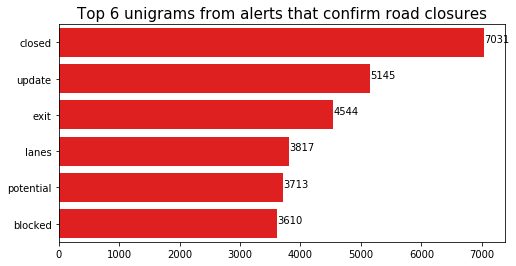

In [19]:
# Set up variables to contain top 5 most used words 
wc1_tweets_cvec = tweets_cvec.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(wc1_tweets_cvec.values, wc1_tweets_cvec.index, 'Top 6 unigrams from alerts that confirm road closures','r')

#### Create Dataframe of Tweets that do not mention closures

In [20]:
# Remove all road closure tweets from full dataframe
tweets_open = tweets[tweets['road_closure'] == 0]

# Shape
tweets_open.shape

(10674, 10)

In [21]:
# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec = cv.fit_transform(tweets_open['text'])

# Convert cvec into a DataFrame
tweets_cvec = pd.DataFrame(cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect new DF
print(tweets_cvec.shape)

(10674, 2858)


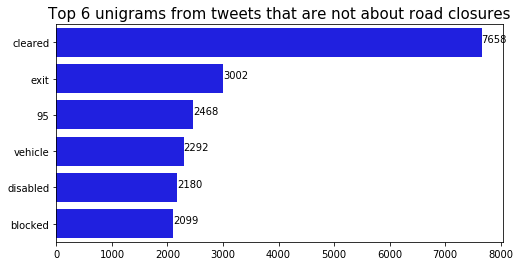

In [22]:
# Set up variables to contain top 5 most used words 
wc1_tweets_cvec = tweets_cvec.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(wc1_tweets_cvec.values, wc1_tweets_cvec.index, 'Top 6 unigrams from tweets that are not about road closures','b')

#### Create Training Dataframe

In [23]:
# copy dataframe
tweets_training = tweets
tweets_training.shape

(24054, 10)

In [24]:
tweets_training.head()

,date,geo,hashtags,id,text,type,username,state,tweet,road_closure
0,2016-10-11 16:39:51+00:00,NaN,NaN,785882618852147201,the pioh for the sr 138 i-20 is going on now until 8 – at american legion post 77,official,GDOTATL,Georgia,The PIOH for the SR 138 I-20 is going on now until 8 – at American Legion Post 77,0
1,2016-10-10 19:10:23+00:00,NaN,NaN,785558112682053632,we appreciate all the hard work our crews have done the last few days they were incredibly dedicated to getting you home safe pc,official,GDOTATL,Georgia,We appreciate all the hard work our crews have done the last few days They were incredibly dedicated to getting you home safe PC,0
2,2016-10-09 17:30:22+00:00,NaN,NaN,785170555456647168,need info on re-entry check here also follow our partners 511georgia,official,GDOTATL,Georgia,Need info on re-entry Check here Also follow our partners 511Georgia,0
3,2016-10-09 15:45:11+00:00,NaN,NaN,785144083685793792,do you need some updates you can find all of them right here,official,GDOTATL,Georgia,Do you need some updates You can find ALL of them right here,0
4,2016-10-09 14:00:20+00:00,NaN,NaN,785117697583427585,did you know that the 511georgia website and app can give you details on road closures,official,GDOTATL,Georgia,Did you know that the 511Georgia website and app can give you details on road closures,1


# Modeling

In [25]:
# Baseline score
tweets_training['road_closure'].value_counts(normalize=True)

1    0.556248
0    0.443752
Name: road_closure, dtype: float64

In [26]:
# define our variables
X = tweets_training['text']
y = tweets_training['road_closure']

In [27]:
# train test split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

In [28]:
# function to find best hyperparameters through a pipeline and gridsearch
# modified code from Arielle Miro

def model_fit_score(X, y,
                    vect_name, vect_type,
                    model_name,
                    model_type,
                    parameters={}):

    pipe = Pipeline([
        (vect_name,vect_type),
        (model_name, model_type)])
    
    # perform gridsearch
    grid = GridSearchCV(pipe, param_grid=parameters, scoring='roc_auc', cv=3, n_jobs = -1, verbose = 1)
    grid = grid.fit(X, y)

    # Print best attributes
    print(f"For model: {model_name}")
    print("-" * 80)
    print(f"The best parameters are: \n {grid.best_params_}")
    print("-" * 80)
    print(f"The best score is: \n {grid.best_score_:.4f}")
    print("-" * 80)
    
    return grid

In [29]:
# inital parameter grid for gridsearch function
params_vec = {
    'vec__max_features': [200, 500, 1000],
    'vec__min_df': [.01, .02],
    'vec__max_df': [.8, .95],
    'vec__ngram_range': [(1,2), (1,3), (2,2), (2,3)],
    'vec__stop_words': [None, 'english']
}

params_lr = {
    'lr__C': [1.0],
    'lr__solver': ['liblinear'],
    'lr__penalty': ['l1', 'l2']
}
    
params_gb = {
    'gb__learning_rate': [0.1, 0.2, 0.5],
    'gb__n_estimators': [50, 100, 200, 500],
    'gb__min_samples_split': [2, 3, 5],
    'gb__min_samples_leaf': [1],
    'gb__max_depth': [2, 3, 5]
}

In [30]:
# optimal parameters so the code runs faster
# convert cell to code to make notebook take these parameters
params_vec = {
    'vec__max_features': [500],
    'vec__min_df': [.01],
    'vec__max_df': [.95],
    'vec__ngram_range': [(1,3)],
    'vec__stop_words': ['english']}

params_lr = {
    'lr__penalty': ['l1'],
    'lr__C': [1.0]}

params_gb = {
    'gb__learning_rate': [0.1],
    'gb__n_estimators': [200],
    'gb__max_depth': [5],
    'gb__min_samples_leaf': [1],
    'gb__min_samples_split': [2]}

In [31]:
# function to visualize confusion matrix
# Source code from SkLearn documentation
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [32]:
# function to plot regression coeficients for NLP models
# modified code from jasmine vasandani
def regression_coef_plot(estimator, vectorizor):
    # Create list of logistic regression coefficients 
    lr_coef = np.array(estimator.coef_).tolist()
    lr_coef = lr_coef[0]

    # create dataframe from lasso coef
    lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
    vectorizor.get_feature_names(), columns = ["lr_coef"])

    # sort the values from high to low
    lr_coef = lr_coef.sort_values(by = 'lr_coef', 
    ascending = False)

    # Create top and bottom 10 
    df_head = lr_coef.head(10)
    df_tail = lr_coef.tail(10)

    # merge back together
    df_merged = pd.concat([df_head, df_tail], axis=0)

    # plot the sorted dataframe
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    fig.suptitle('Coefficients', size=14)
    ax = sns.barplot(x = 'lr_coef', y= df_merged.index, 
    data=df_merged, palette= 'cubehelix')
    ax.set(xlabel='Regression Coefficients')
    plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [33]:
# helper functions for ROC AUC curve
# modified code from Arielle Miro

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

In [34]:
# function to plot ROC AUC curve
# modified code from Tim Book
def roc_auc(X, y, estimator):
    
    # Create figure.
    plt.figure(figsize = (12,10))
    
    # calculate predicted probabilities
    pred_proba = [i[1] for i in estimator.predict_proba(X)]

    pred_df = pd.DataFrame({'true_values': y,
                            'pred_probs':pred_proba})

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
    plt.title(f'ROC Curve with AUC = {roc_auc_score(y, estimator.predict(X))}', fontsize=22)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);

## Logistic Regression with Count Vectorizor

In [35]:
# create model using grisearch function
lr_cvec = model_fit_score(X_train, 
                          y_train, 
                          'vec', CountVectorizer(), 
                          'lr', LogisticRegression(),
                          parameters = {**params_vec, **params_lr})

# save the model to disk
filename = '../data/Models/lr_cvec_07302019.sav'
pickle.dump(lr_cvec, open(filename, 'wb'))

# Print Training and Test scores 
print(f"Train set Score: \n {lr_cvec.score(X_train, y_train)}")
print(f"Test set Score: \n {lr_cvec.score(X_test, y_test)}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished
C:\Users\templ\Anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For model: lr
--------------------------------------------------------------------------------
The best parameters are: 
 {'lr__C': 1.0, 'lr__penalty': 'l1', 'vec__max_df': 0.95, 'vec__max_features': 500, 'vec__min_df': 0.01, 'vec__ngram_range': (1, 3), 'vec__stop_words': 'english'}
--------------------------------------------------------------------------------
The best score is: 
 0.9987
--------------------------------------------------------------------------------
Train set Score: 
 0.9992618402735957
Test set Score: 
 0.9988479811106985


In [36]:
# run logistic regression model based on the gridsearch
# Instantiate the classifier and vectorizer
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec = CountVectorizer(ngram_range=(1, 3), max_df= 0.95, max_features= 500, min_df = 0.01, stop_words= None)

# Fit and transform the vectorizor
cvec.fit(X_train)

cvec_train = cvec.transform(X_train)
cvec_test = cvec.transform(X_test)

# Fit the classifier
lr.fit(cvec_train,y_train)

# Create the predictions for Y training data
y_pred = lr.predict(cvec_test)

print(f'Train Score: {lr.score(cvec_train, y_train)}')
print(f'Test Score: {lr.score(cvec_test, y_test)}')

Train Score: 0.98980044345898
Test Score: 0.9873628200864649


Confusion matrix, without normalization
[[2634   35]
 [  58 3287]]


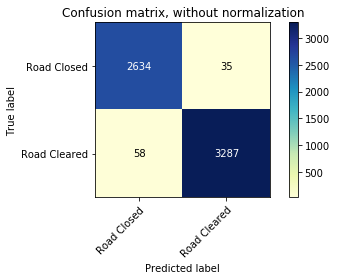

In [37]:
# set decimal places for numpy functions
np.set_printoptions(precision=2)

#define class names
class_names=np.array(['Road Closed', 'Road Cleared'])

# generate predictions
y_pred = lr_cvec.predict(X_test)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')


plt.show();

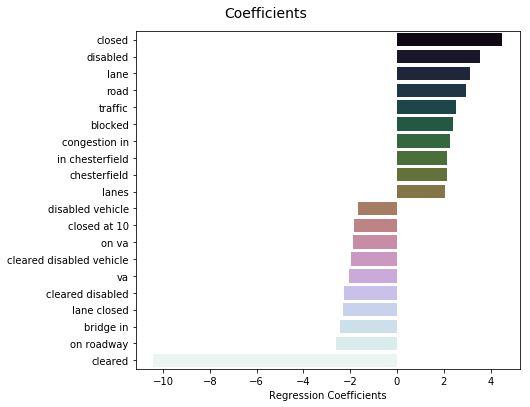

In [38]:
# run regression coeficient plot
regression_coef_plot(lr, cvec)

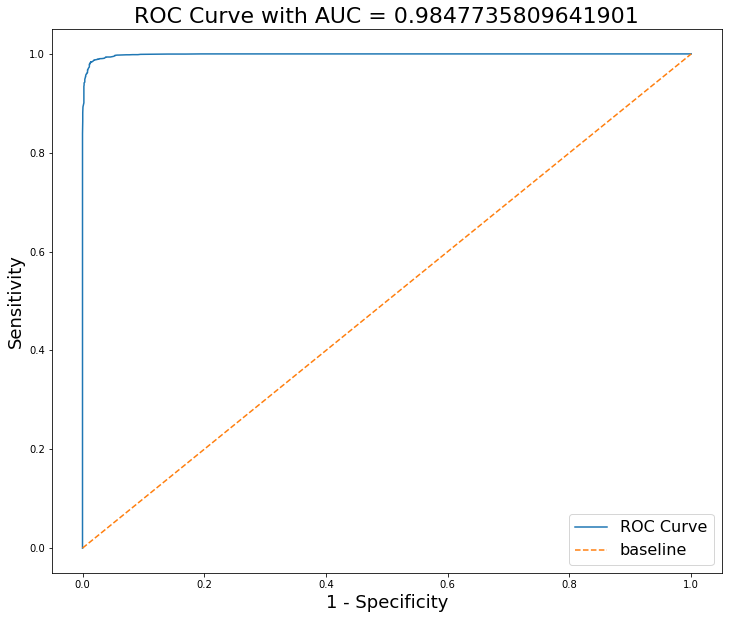

In [39]:
# run AUC ROC curve function
roc_auc(X_test, y_test, lr_cvec)

## TF-IDF and Gradient Boosting

In [40]:
gb_tvec = model_fit_score(X_train, y_train,         
                vect_name = 'vec',
                vect_type = TfidfVectorizer(),               
                model_name ='gb',          
                model_type = GradientBoostingClassifier(),
                parameters = {**params_vec, **params_gb})

# save the model to disk
filename = '../data/Models/gb_tvec_07302019.sav'
pickle.dump(gb_tvec, open(filename, 'wb'))

# Print Training and Test scores 
print(f"Train set Score: \n {gb_tvec.score(X_train, y_train)}")
print(f"Test set Score: \n {gb_tvec.score(X_test, y_test)}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.3s finished


For model: gb
--------------------------------------------------------------------------------
The best parameters are: 
 {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__min_samples_leaf': 1, 'gb__min_samples_split': 2, 'gb__n_estimators': 200, 'vec__max_df': 0.95, 'vec__max_features': 500, 'vec__min_df': 0.01, 'vec__ngram_range': (1, 3), 'vec__stop_words': 'english'}
--------------------------------------------------------------------------------
The best score is: 
 0.9985
--------------------------------------------------------------------------------
Train set Score: 
 0.999937719543123
Test set Score: 
 0.9990585591867207


Confusion matrix, without normalization
[[2645   24]
 [  29 3316]]


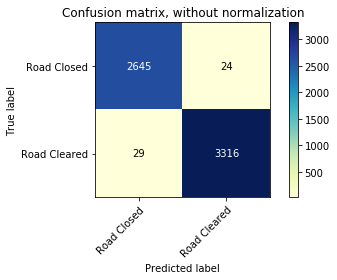

In [41]:
# generate predictions
y_pred = gb_tvec.predict(X_test)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')


plt.show();

In [42]:
# run gradient boosting classifier based on the gridsearch
# Instantiate the classifier and vectorizer
gb = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, 
                                min_samples_leaf = 1, min_samples_split = 2, 
                                n_estimators = 200)
tvec = TfidfVectorizer(ngram_range=(1, 3), max_df= 0.95, max_features= 500, min_df = 0.01, stop_words= 'english')

# Fit and transform the vectorizor
tvec.fit(X_train)

tvec_train = cvec.transform(X_train)
tvec_test = cvec.transform(X_test)

# Fit the classifier
gb.fit(tvec_train, y_train)

# Create the predictions for Y training data
y_pred = gb.predict(tvec_test)

print(f'Train Score: {gb.score(tvec_train, y_train)}')
print(f'Test Score: {gb.score(tvec_test, y_test)}')

Train Score: 0.9978935698447894
Test Score: 0.9940139674093781


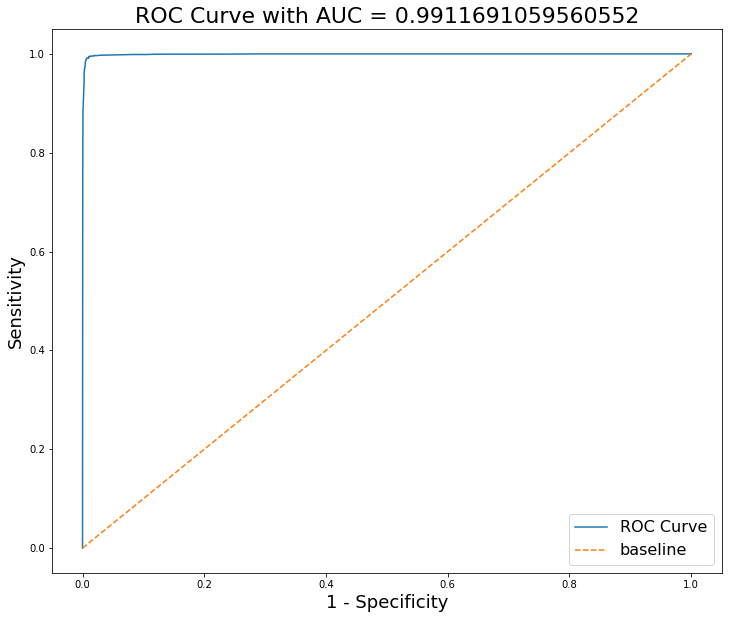

In [43]:
# run AUC ROC curve function
roc_auc(X_test, y_test, gb_tvec)

## Export Training Dataframe

In [44]:
tweets_training.head()

,date,geo,hashtags,id,text,type,username,state,tweet,road_closure
0,2016-10-11 16:39:51+00:00,NaN,NaN,785882618852147201,the pioh for the sr 138 i-20 is going on now until 8 – at american legion post 77,official,GDOTATL,Georgia,The PIOH for the SR 138 I-20 is going on now until 8 – at American Legion Post 77,0
1,2016-10-10 19:10:23+00:00,NaN,NaN,785558112682053632,we appreciate all the hard work our crews have done the last few days they were incredibly dedicated to getting you home safe pc,official,GDOTATL,Georgia,We appreciate all the hard work our crews have done the last few days They were incredibly dedicated to getting you home safe PC,0
2,2016-10-09 17:30:22+00:00,NaN,NaN,785170555456647168,need info on re-entry check here also follow our partners 511georgia,official,GDOTATL,Georgia,Need info on re-entry Check here Also follow our partners 511Georgia,0
3,2016-10-09 15:45:11+00:00,NaN,NaN,785144083685793792,do you need some updates you can find all of them right here,official,GDOTATL,Georgia,Do you need some updates You can find ALL of them right here,0
4,2016-10-09 14:00:20+00:00,NaN,NaN,785117697583427585,did you know that the 511georgia website and app can give you details on road closures,official,GDOTATL,Georgia,Did you know that the 511Georgia website and app can give you details on road closures,1


In [45]:
tweets_training.to_csv('../data/cleaned_tweets/cleaned_historic_official_07312019.csv', index = False)